## Multimodal Early Fusion NN
#### Complex model: BiLSTM + MultiHeadAttention + EfficientNet + Residual Dense Blocks

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate,
    GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Add,
    SpatialDropout1D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

In [3]:
df = pd.read_csv("FoodFactsCleaned.csv")
df["nutriscore_letter"] = df["nutriscore_letter"].astype(int) 

In [17]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"       
IMAGE_COL = "image_160_path"   

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Text tokenization
MAX_WORDS = 30000
MAX_LEN = 200

# Image settings
IMG_SIZE = (160, 160)

# NN training
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
needed = TEXT_COLS + TABULAR_COLS + [TARGET_COL, IMAGE_COL]
# Ensure text columns are strings
for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)

# Concatenate text into one document per row
df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

# Prepare arrays
X_text = df["text_concat"].values
X_tab  = df[TABULAR_COLS].values.astype(np.float32)
X_img  = df[IMAGE_COL].astype(str).values
y = df[TARGET_COL].values

num_classes = len(np.unique(y))
print("Classes:", num_classes)

Classes: 5


In [8]:
# ---- Global split: Train / Val / Test ----
X_text_tv, X_text_te, X_tab_tv,  X_tab_te, X_img_tv,  X_img_te, y_tv, y_te = train_test_split(
    X_text, X_tab, X_img, y,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y
)

X_text_tr, X_text_val, X_tab_tr,  X_tab_val, X_img_tr,  X_img_val, y_tr, y_val = train_test_split(
    X_text_tv, X_tab_tv, X_img_tv, y_tv,
    test_size=0.1765,   # ≈ 15% of total
    random_state=RANDOM_STATE,
    stratify=y_tv
)

print("Train:", len(y_tr), "Val:", len(y_val), "Test:", len(y_te))

Train: 3596 Val: 771 Test: 771


In [9]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

def tokenize_and_pad(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")

X_text_tr_pad  = tokenize_and_pad(X_text_tr)
X_text_val_pad = tokenize_and_pad(X_text_val)
X_text_te_pad  = tokenize_and_pad(X_text_te)

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)


In [10]:
scaler = StandardScaler()
X_tab_tr_sc  = scaler.fit_transform(X_tab_tr).astype(np.float32)
X_tab_val_sc = scaler.transform(X_tab_val).astype(np.float32)
X_tab_te_sc  = scaler.transform(X_tab_te).astype(np.float32)

tab_dim = X_tab_tr_sc.shape[1]


In [14]:
def load_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = eff_preprocess(img)
    return img


In [ ]:
def make_dataset(text_pad, tab_sc, img_paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((text_pad, tab_sc, img_paths, labels))

    def _map(text_ids, tab_vec, img_path, label):
        img = load_image(img_path)
        return {"text_in": text_ids, "tab_in": tab_vec, "img_in": img}, label

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=RANDOM_STATE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [18]:
train_ds = make_dataset(X_text_tr_pad,  X_tab_tr_sc,  X_img_tr,  y_tr,  training=True)
val_ds   = make_dataset(X_text_val_pad, X_tab_val_sc, X_img_val, y_val, training=False)
test_ds  = make_dataset(X_text_te_pad,  X_tab_te_sc,  X_img_te,  y_te,  training=False)


In [20]:
def residual_dense_block(x, units, dropout=0.3, name_prefix="res"):
    skip = x
    x = Dense(units, activation="relu", name=f"{name_prefix}_dense1")(x)
    x = BatchNormalization(name=f"{name_prefix}_bn1")(x)
    x = Dropout(dropout, name=f"{name_prefix}_drop1")(x)
    x = Dense(units, activation=None, name=f"{name_prefix}_dense2")(x)
    x = BatchNormalization(name=f"{name_prefix}_bn2")(x)
    x = Add(name=f"{name_prefix}_add")([skip, x])
    x = tf.keras.layers.Activation("relu", name=f"{name_prefix}_relu")(x)
    return x


def build_model(vocab_size, max_len, tab_dim, num_classes):
    # ----- Inputs -----
    text_in = Input(shape=(max_len,), dtype=tf.int32, name="text_in")
    tab_in  = Input(shape=(tab_dim,), dtype=tf.float32, name="tab_in")
    img_in  = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32, name="img_in")

    # =========================
    # Text branch (BASELINE)
    # =========================
    x_text = Embedding(vocab_size, 128, name="txt_embed")(text_in)
    x_text = GlobalAveragePooling1D(name="txt_gap")(x_text)
    x_text = Dropout(0.3, name="txt_drop")(x_text)

    text_vec = Dense(256, activation="relu", name="txt_dense")(x_text)
    text_vec = BatchNormalization(name="txt_bn")(text_vec)
    text_vec = Dropout(0.35, name="txt_drop2")(text_vec)

    # =========================
    # Tabular branch
    # =========================
    tab_vec = BatchNormalization(name="tab_bn0")(tab_in)
    tab_vec = Dense(256, activation="relu", name="tab_dense1")(tab_vec)
    tab_vec = BatchNormalization(name="tab_bn1")(tab_vec)
    tab_vec = Dropout(0.35, name="tab_drop1")(tab_vec)
    tab_vec = Dense(128, activation="relu", name="tab_dense2")(tab_vec)
    tab_vec = Dropout(0.25, name="tab_drop2")(tab_vec)

    # =========================
    # Image branch
    # =========================
    backbone = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")
    backbone.trainable = False

    img_vec = backbone(img_in)
    img_vec = Dense(256, activation="relu", name="img_dense")(img_vec)
    img_vec = BatchNormalization(name="img_bn")(img_vec)
    img_vec = Dropout(0.35, name="img_drop")(img_vec)

    # =========================
    # Early fusion
    # =========================
    fused = Concatenate(name="early_fusion_concat")(
        [text_vec, tab_vec, img_vec]
    )

    # =========================
    # Fusion network + residuals
    # =========================
    x = Dense(512, activation="relu", name="fusion_dense1")(fused)
    x = BatchNormalization(name="fusion_bn1")(x)
    x = Dropout(0.45, name="fusion_drop1")(x)

    x = Dense(512, activation="relu", name="fusion_proj")(x)
    x = residual_dense_block(x, 512, dropout=0.35, name_prefix="res1")
    x = residual_dense_block(x, 512, dropout=0.35, name_prefix="res2")

    x = Dense(256, activation="relu", name="fusion_dense2")(x)
    x = BatchNormalization(name="fusion_bn2")(x)
    x = Dropout(0.35, name="fusion_drop2")(x)

    # =========================
    # Output
    # =========================
    out = Dense(num_classes, activation="softmax", name="out")(x)

    model = Model(inputs=[text_in, tab_in, img_in], outputs=out)
    return model


In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

In [25]:
model = build_model(vocab_size, MAX_LEN, tab_dim, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.3840 - loss: 1.7901 - val_accuracy: 0.5422 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - accuracy: 0.5484 - loss: 1.1051 - val_accuracy: 0.5577 - val_loss: 0.9603 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.6182 - loss: 0.9108 - val_accuracy: 0.6407 - val_loss: 0.7921 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.6510 - loss: 0.8193 - val_accuracy: 0.6706 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - accuracy: 0.6944 - loss: 0.7496 - val_accuracy: 0.6952 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - accuracy: 0.6949 - loss: 0.7283 - val_accuracy: 0.7497 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - accuracy: 0.7080 - loss: 0.

In [27]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.771725058555603


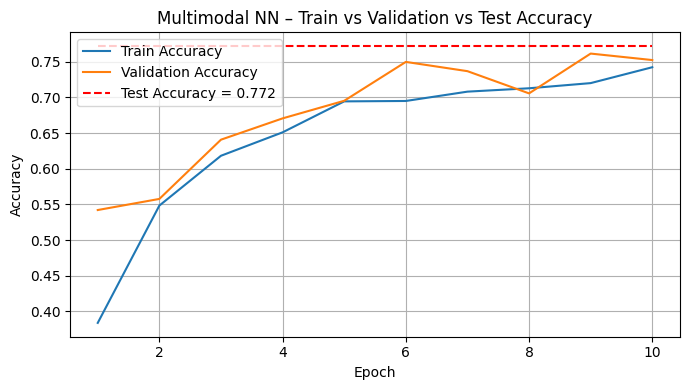

In [29]:

epochs = np.arange(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(7, 4))

# Training & validation curves
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")

# Test accuracy as horizontal line
plt.hlines(
    y=test_acc,
    xmin=epochs[0],
    xmax=epochs[-1],
    colors="red",
    linestyles="dashed",
    label=f"Test Accuracy = {test_acc:.3f}"
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Multimodal NN – Train vs Validation vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.models import Model

feature_extractor = Model(
    inputs=model.input,
    outputs=model.get_layer("fusion_dense2").output
)


In [31]:
Z_tr  = feature_extractor.predict(train_ds, verbose=1)
Z_val = feature_extractor.predict(val_ds, verbose=1)
Z_te  = feature_extractor.predict(test_ds, verbose=1)

print("Embedding shapes:")
print("Train:", Z_tr.shape)
print("Val:  ", Z_val.shape)
print("Test: ", Z_te.shape)


57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step
Embedding shapes:
Train: (3596, 256)
Val:   (771, 256)
Test:  (771, 256)
